In [1]:
import itertools
import matplotlib
import os
import re
import tensorflow
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['figure.figsize'] = 16, 10
matplotlib.rcParams['text.color'] 
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

plt.style.use('fivethirtyeight')

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

warnings.filterwarnings('ignore')

epochs = 50
batch_size = 250
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [2]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors, x, y, nrows, ncols):
    n = 0
    nrows = nrows
    ncols = ncols
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((x, y)),  cmap = "gray")
            ax[row, col].set_title("Predicted label: {}\nTrue label: {}".format(pred_errors[error], obs_errors[error]))
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])
            ax[row, col].set_xticklabels([])
            ax[row, col].set_yticklabels([])
            n += 1

In [3]:
(X_train_MNIST, Y_train_MNIST), (X_test_MNIST, Y_test_MNIST) = mnist.load_data()

In [4]:
Y_MNIST = np.concatenate((Y_train_MNIST, Y_test_MNIST), axis = None)

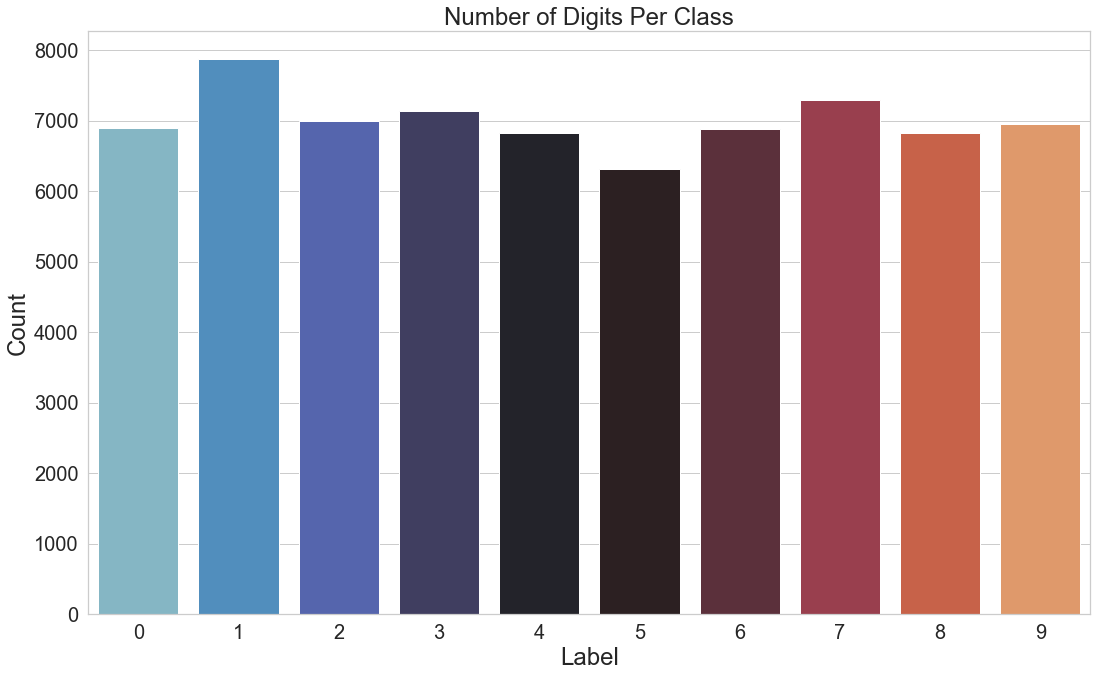

In [5]:
plt.figure()
g = sns.countplot(Y_MNIST, palette="icefire")
plt.title("Number of Digits Per Class", fontsize = '24')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.xlabel("Label", fontsize = '24')
plt.ylabel("Count", fontsize = '24')
Values, Counts = np.unique(Y_MNIST, return_counts=True)

In [6]:
VC_MNIST = pd.DataFrame({'Values': Values, 'Counts': Counts})
VC_MNIST = VC_MNIST.style.hide_index()
VC_MNIST

Values,Counts
0,6903
1,7877
2,6990
3,7141
4,6824
5,6313
6,6876
7,7293
8,6825
9,6958


In [7]:
X_train_MNIST = X_train_MNIST / 255.
X_test_MNIST = X_test_MNIST / 255.

In [8]:
X_train_MNIST = X_train_MNIST.reshape(-1, 28, 28, 1)
X_test_MNIST = X_test_MNIST.reshape (-1, 28, 28, 1)
X_train_MNIST.shape, X_train_MNIST.shape

((60000, 28, 28, 1), (60000, 28, 28, 1))

In [9]:
Y_train_MNIST = to_categorical(Y_train_MNIST)
Y_test_MNIST = to_categorical(Y_test_MNIST)
Y_train_MNIST.shape, Y_test_MNIST.shape

((60000, 10), (10000, 10))

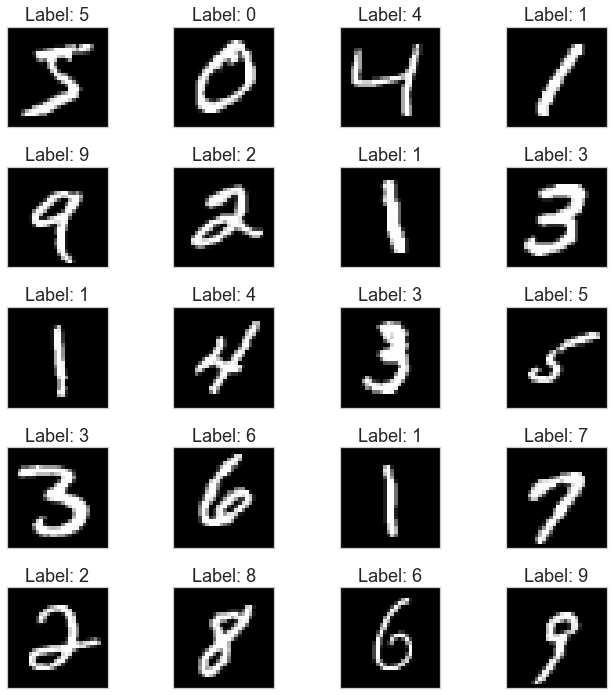

In [10]:
num = 20
images = X_train_MNIST[:num]

num_row = 5
num_col = 4

fig, axes = plt.subplots(num_row, num_col, figsize=(10, 10))

for i in range(num):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(images[i].reshape(28, 28), cmap='gray')
    ax.set_title('Label: {}'.format(Y_train_MNIST[i].tolist().index(1.0, 0, 10)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()

In [11]:
X_train_MNIST, X_val_MNIST, Y_train_MNIST, Y_val_MNIST = train_test_split(X_train_MNIST, Y_train_MNIST, test_size = 0.2, random_state=10)
X_train_MNIST.shape, X_val_MNIST.shape, Y_train_MNIST.shape, Y_val_MNIST.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [ ]:
reduce_learning = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [ ]:
model_MNIST = Sequential()
model_MNIST.add(Conv2D(filters = 8, kernel_size = (5, 5), padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))
model_MNIST.add(MaxPool2D(pool_size=(2, 2)))
model_MNIST.add(Dropout(0.25))
model_MNIST.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model_MNIST.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model_MNIST.add(Dropout(0.25))
model_MNIST.add(Flatten())
model_MNIST.add(Dense(256, activation = "relu"))
model_MNIST.add(Dropout(0.5))
model_MNIST.add(Dense(10, activation = "softmax"))
model_MNIST.summary()

In [ ]:
plot_model(model_MNIST, "MNIST_Classifier.png", show_shapes=True)

In [ ]:
model_MNIST.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
datagen_MNIST = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen_MNIST.fit(X_train_MNIST)

In [ ]:
history_MNIST = model_MNIST.fit_generator(datagen_MNIST.flow(X_train_MNIST, Y_train_MNIST, batch_size = batch_size), epochs = epochs, validation_data = (X_val_MNIST, Y_val_MNIST), steps_per_epoch = X_train_MNIST.shape[0] // batch_size, callbacks = callbacks)

In [ ]:
acc_MNIST = history_MNIST.history['accuracy']
val_acc_MNIST = history_MNIST.history['val_accuracy']
loss_MNIST = history_MNIST.history['loss']
val_loss_MNIST = history_MNIST.history['val_loss']
epochs_graph = range(1, len(acc_MNIST) + 1)

plt.title('Training and Validation Accuracy', fontsize = '24')
plt.xlabel("Epochs", fontsize = '24')
plt.ylabel("Accuracy", fontsize = '24')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.plot(epochs_graph, acc_MNIST, 'red', label='Training accuracy')
plt.plot(epochs_graph, val_acc_MNIST, 'blue', label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and Validation Loss', fontsize = '24')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.xlabel("Epochs", fontsize = '24')
plt.ylabel("Loss", fontsize = '24')
plt.plot(epochs_graph, loss_MNIST, 'red', label='Training loss')
plt.plot(epochs_graph, val_loss_MNIST, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
Y_pred_MNIST = model_MNIST.predict(X_test_MNIST)
Y_pred_classes_MNIST = np.argmax(Y_pred_MNIST, axis = 1) 
Y_truth_MNIST = np.argmax(Y_test_MNIST, axis = 1) 

confusion_mtx_MNIST = confusion_matrix(Y_truth_MNIST, Y_pred_classes_MNIST)

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(confusion_mtx_MNIST, annot=True, linewidths=0.01, cmap="viridis", linecolor="gray", fmt= '.1f', ax = ax)
plt.xlabel("Predicted Label", fontsize = 24)
plt.ylabel("True Label", fontsize = 24)
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title("Confusion Matrix", fontsize = '24')
plt.show()

In [ ]:
np.sum(Y_truth_MNIST == Y_pred_classes_MNIST) / len(Y_truth_MNIST)

In [ ]:
errors_MNIST = (Y_pred_classes_MNIST - Y_truth_MNIST != 0)

Y_pred_classes_errors_MNIST = Y_pred_classes_MNIST[errors_MNIST]
Y_pred_errors_MNIST = Y_pred_MNIST[errors_MNIST]
Y_true_errors_MNIST = Y_truth_MNIST[errors_MNIST]
X_test_errors_MNIST = X_test_MNIST[errors_MNIST]


Y_pred_errors_prob_MNIST = np.max(Y_pred_errors_MNIST, axis = 1)
True_prob_errors_MNIST = np.diagonal(np.take(Y_pred_errors_MNIST, Y_true_errors_MNIST, axis=1))
Delta_pred_true_errors_MNIST = Y_pred_errors_prob_MNIST - True_prob_errors_MNIST
Sorted_dela_errors_MNIST = np.argsort(Delta_pred_true_errors_MNIST)
Most_important_errors_MNIST = Sorted_dela_errors_MNIST[-16:]

display_errors(Most_important_errors_MNIST, X_test_errors_MNIST, Y_pred_classes_errors_MNIST, Y_true_errors_MNIST, 28, 28, 4, 4)

In [ ]:
Data = np.transpose(np.loadtxt("Digits_Dataset.txt"))
Data = Data.transpose()
Data = Data.astype(int)
Data.shape

In [ ]:
x = 0
Classes = np.array([])
Classes = Classes.astype(int)

for i in range(1, 2001):
    Classes = np.append(Classes, x)
    if(i != 0 and i % 200 == 0):
        x = x + 1
        continue

In [ ]:
batch_size = 25

In [ ]:
X_Digits, X_test_Digits, Y_Digits, Y_test_Digits = train_test_split(Data, Classes, test_size=0.2, stratify = Classes, random_state=10)

In [ ]:
Y_Digits_Total = np.concatenate((Y_Digits, Y_test_Digits), axis = None)

In [ ]:
plt.figure()
g = sns.countplot(Y_Digits_Total, palette="icefire")
plt.title("Number of Digits Per Class", fontsize = '24')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.xlabel("Label", fontsize = '24')
plt.ylabel("Count", fontsize = '24')
Values, Counts = np.unique(Y_Digits_Total, return_counts=True)

In [ ]:
VC_Digits = pd.DataFrame({'Values': Values, 'Counts': Counts})
VC_Digits = VC_Digits.style.hide_index()
VC_Digits

In [ ]:
X_Digits = X_Digits / 6.
X_test_Digits = X_test_Digits / 6.

In [ ]:
X_Digits = X_Digits.reshape(-1, 16, 15, 1)
X_test_Digits = X_test_Digits.reshape (-1, 16, 15, 1)
X_Digits.shape, X_test_Digits.shape

In [ ]:
Y_Digits = to_categorical(Y_Digits)
Y_test_Digits = to_categorical(Y_test_Digits)
Y_Digits.shape, Y_test_Digits.shape

In [ ]:
X_train_Digits, X_val_Digits, Y_train_Digits, Y_val_Digits = train_test_split(X_Digits, Y_Digits, test_size = 0.2, random_state=10, stratify = Y_Digits)
X_train_Digits.shape, X_val_Digits.shape, Y_train_Digits.shape, Y_val_Digits.shape

In [ ]:
num = 20
images = X_Digits[:num]

num_row = 5
num_col = 4

fig, axes = plt.subplots(num_row, num_col, figsize=(10, 10))

for i in range(num):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(images[i].reshape(16, 15), cmap='gray')
    ax.set_title('Label: {}'.format(Y_Digits[i].tolist().index(1.0, 0, 10)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()

In [ ]:
datagen_Digits = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen_Digits.fit(X_train_Digits)

In [ ]:
model_Digits = Sequential()
model_Digits.add(Conv2D(filters = 8, kernel_size = (5, 5), padding = 'Same', activation = 'relu', input_shape = (16, 15, 1)))
model_Digits.add(MaxPool2D(pool_size=(2, 2)))
model_Digits.add(Dropout(0.25))
model_Digits.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model_Digits.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model_Digits.add(Dropout(0.25))
model_Digits.add(Flatten())
model_Digits.add(Dense(256, activation = "relu"))
model_Digits.add(Dropout(0.5))
model_Digits.add(Dense(10, activation = "softmax"))
model_Digits.summary()

In [ ]:
plot_model(model_Digits, "Digits_Classifier.png", show_shapes=True)

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model_Digits.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history_Digits = model_Digits.fit_generator(datagen_Digits.flow(X_train_Digits, Y_train_Digits, batch_size = batch_size), epochs = epochs, validation_data = (X_val_Digits, Y_val_Digits), steps_per_epoch = X_train_Digits.shape[0] // batch_size, callbacks = callbacks)

In [ ]:
acc_Digits = history_Digits.history['accuracy']
val_acc_Digits = history_Digits.history['val_accuracy']
loss_Digits = history_Digits.history['loss']
val_loss_Digits = history_Digits.history['val_loss']
epochs_graph = range(1, len(acc_Digits) + 1)

plt.title('Training and Validation Accuracy', fontsize = '24')
plt.xlabel("Epochs", fontsize = '24')
plt.ylabel("Accuracy", fontsize = '24')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.plot(epochs_graph, acc_Digits, 'red', label='Training accuracy')
plt.plot(epochs_graph, val_acc_Digits, 'blue', label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and Validation Loss', fontsize = '24')
plt.xlabel("Epochs", fontsize = '24')
plt.ylabel("Loss", fontsize = '24')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.plot(epochs_graph, loss_Digits, 'red', label='Training loss')
plt.plot(epochs_graph, val_loss_Digits, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [ ]:
Y_pred_Digits = model_Digits.predict(X_test_Digits)
Y_pred_classes_Digits = np.argmax(Y_pred_Digits, axis = 1) 
Y_truth_Digits = np.argmax(Y_test_Digits, axis = 1) 

confusion_mtx_Digits = confusion_matrix(Y_truth_Digits, Y_pred_classes_Digits)

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(confusion_mtx_Digits, annot=True, linewidths=0.01, cmap="viridis", linecolor="gray", fmt= '.1f', ax = ax)
plt.xlabel("Predicted Label", fontsize = '24')
plt.ylabel("True Label", fontsize = '24')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title("Confusion Matrix", fontsize = '24')
plt.show()

In [ ]:
np.sum(Y_truth_Digits == Y_pred_classes_Digits) / len(Y_truth_Digits)

In [ ]:
errors_Digits = (Y_pred_classes_Digits - Y_truth_Digits != 0)

Y_pred_classes_errors_Digits = Y_pred_classes_Digits[errors_Digits]
Y_pred_errors_Digits = Y_pred_Digits[errors_Digits]
Y_true_errors_Digits = Y_truth_Digits[errors_Digits]
X_test_errors_Digits = X_test_Digits[errors_Digits]

Y_pred_errors_prob_Digits = np.max(Y_pred_errors_Digits, axis = 1)
True_prob_errors_Digits = np.diagonal(np.take(Y_pred_errors_Digits, Y_true_errors_Digits, axis=1))
Delta_pred_true_errors_Digits = Y_pred_errors_prob_Digits - True_prob_errors_Digits
Sorted_dela_errors_Digits = np.argsort(Delta_pred_true_errors_Digits)
Most_important_errors_Digits = Sorted_dela_errors_Digits[-16:]


display_errors(Most_important_errors_Digits, X_test_errors_Digits, Y_pred_classes_errors_Digits, Y_true_errors_Digits, 16, 15, 2, 4)

# Load previous models

## MNIST

In [ ]:
model_MNIST.save('saved_models/MNIST_Model')

In [ ]:
model_MNIST = tensorflow.keras.models.load_model('saved_models/MNIST_Model')
model_MNIST.summary()

In [ ]:
loss_MNIST, acc_MNIST = model_MNIST.evaluate(X_test_MNIST, Y_test_MNIST, verbose=2)

## Digits

In [ ]:
model_Digits.save('saved_models/Digits_Model')

In [ ]:
model_Digits = tensorflow.keras.models.load_model('saved_models/Digits_Model')
model_Digits.summary()

In [ ]:
loss_Digits, acc_Digits = model_Digits.evaluate(X_test_Digits, Y_test_Digits, verbose=2)

# Visualize activations

In [12]:
test_im = X_train_MNIST[154]
test_im = test_im.reshape((1,) + test_im.shape)

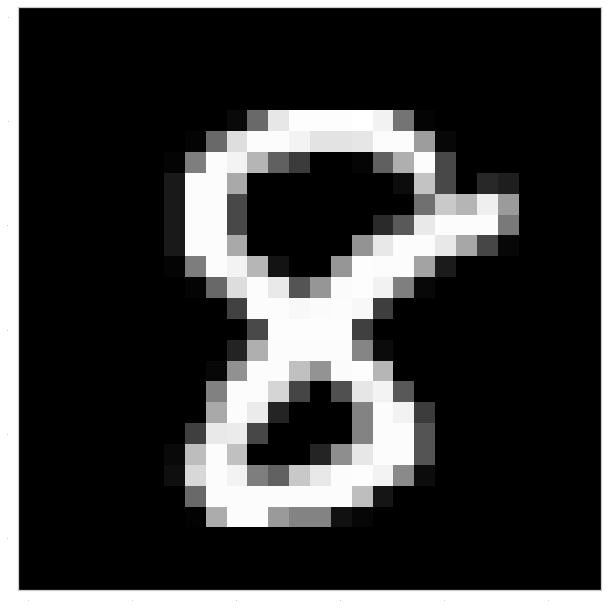

In [17]:
test_im = X_train_MNIST[154]
plt.xticks(fontsize = '0')
plt.yticks(fontsize = '0')
plt.grid(False)
plt.imshow(test_im, cmap = 'gray')

In [ ]:
layer_outputs = [layer.output for layer in model_MNIST.layers]
feature_map_model = tensorflow.keras.models.Model(model_MNIST.input, layer_outputs)
feature_maps = feature_map_model.predict(test_im)

In [ ]:
layer_names = []
for layer in model_MNIST.layers:
    layer_names.append(layer.name) 
images_per_row = 4
for layer_name, layer_activation in zip(layer_names, feature_maps):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.xticks(fontsize = '0')
        plt.yticks(fontsize = '0')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

In [ ]:
for layer_name, layer_activation in zip(layer_names, feature_maps):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.xticks(fontsize = '0')
        plt.yticks(fontsize = '0')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

# Visualize data augmentation

In [ ]:
gen = datagen_MNIST.flow(X_train_MNIST, batch_size = batch_size)
x = gen.next()
for i in range(0,18):
    image = x[i]
    plt.imshow(image)
    plt.show()